## Names: 
### Jaagrit Arora, Sankalp Devasthali, Garvit Harisinghani
## Andrew ID:
### jarora, sdevasth, gharisin

In [1]:
## Import Statements
import cv2
import glob
import ntpath
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')  # prettier plots
%matplotlib inline
from math import floor

#### Variables
**captcha_labels**: labels of a given CAPTCHA image. Eg "A77X" for image bearing CAPTCHA A77X.  
**images**: a list of filepath for images of the dataset.  
**CAP_SIZE**: the maximum number of symbols in the CAPTCHA dataset.  
**X_train_i [~y][~test]**: split of the dataset into train and test images and labels.  
**X_train [~y][~test]**: The actual data and labels we will be training and testing on.  
**models_correctly_classified**: The number of images that have been correctly classified.  
**onehot**: a ONE-HOT encoded representation of all labels within our dataset.  
**IMG_WIDTH**: the width of all our images for representation and training.  
**IMG_HEIGHT**: the width of all our images for representation and training.  

#### Models 
**model**: An SVM model.  
**model_basic**: a basic Neural Network with minimal layers.  
**model_advanced**: an advanced Neural Network with multiple layers.  
**tsne**: a T-SNE model for visualization.

In [2]:
#Data import
captcha_labels = []
images = glob.glob('solving\solving_captchas_code_examples\solving_captchas_code_examples\generated_captcha_images\*.png')
for image in range(len(images)):
    captcha_labels.append(ntpath.basename(images[image]).split('.')[0])
    
IMG_WIDTH = 18
IMG_HEIGHT = 24
CAP_SIZE = max([len(c) for c in captcha_labels])
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(images, captcha_labels, test_size=0.2, random_state=42)

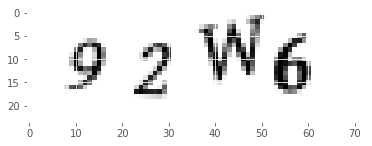

(24, 72, 3)

In [3]:
#Original captcha Image
rand = np.random.randint(len(X_train_i))
temp_captcha = cv2.imread(X_train_i[rand], 1) 
plt.imshow(temp_captcha)
plt.show()
temp_captcha.shape

In [4]:
#Breaking an image into components
def digit_breaker(captcha):
    ratio_threshold = 0.75
    digits = []
    start_col = 0
    h = captcha.shape[0]
    w = captcha.shape[1]
    for column in range(0,w):
        if((start_col == 0) & (np.sum(captcha[:,column])!=255*h)):
            start_col = column
        if((start_col != 0) & (np.sum(captcha[:,column]) == 255*h)):
            end_col = column
            if((end_col-start_col)>=(h*ratio_threshold)):
                mid_col = start_col + int((end_col-start_col+1)/2)
                Z1 = captcha[:,start_col:(mid_col+1)]
                Z2 = captcha[:,mid_col:(end_col+1)]
                digits.append(Z1)
                digits.append(Z2)
            else:
                Z = captcha[:, start_col:(end_col+1)]
                digits.append(Z)
            start_col = 0
            
    return digits

In [5]:
#Function to generate modified training/test dataset
def captcha_dataset(dataset, labels, mode):
    captcha_arr = []
    captcha_labels = []
    digit_arr = []
    digit_labels = []
    digit_flat_arr = []
    h_final, w_final = 24, 18
    
    for image in range(len(dataset)):
        captcha = cv2.imread(dataset[image], 0) 
        _,captcha = cv2.threshold(captcha,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        captcha_arr.append(captcha) #the array of all the captchas
        temp_captcha_label = labels[image]
        captcha_labels.append(temp_captcha_label) #all the captcha labels
        captcha_broken = digit_breaker(np.array(captcha)) # calling function to break the captchas
    
        if (mode == 'test'):
            if(len(captcha_broken) < CAP_SIZE):
                for i in range(4-len(captcha_broken)):
                    dummy = np.full((h_final,w_final),255)
                    captcha_broken.append(dummy)
            elif(len(captcha_broken) > CAP_SIZE):
                captcha_broken = captcha_broken[0:CAP_SIZE]

            for i in range(len(captcha_broken)):
                if(captcha_broken[i].flatten().shape[0] > IMG_WIDTH*IMG_HEIGHT):
                    arr = cv2.resize(captcha_broken[i], (IMG_WIDTH,IMG_HEIGHT))
                else:
                    arr = np.pad(captcha_broken[i], ((0, 0), (0, (IMG_WIDTH-captcha_broken[i].shape[1]))), 'maximum')       
                digit_arr.append(arr)
                digit_labels.append(temp_captcha_label[i])  
                flat_img = np.array(arr).flatten().astype(np.float32) / 255
                digit_flat_arr.append(flat_img)   
        
        elif (mode == 'train' and len(captcha_broken) == CAP_SIZE):
            for i in range(len(captcha_broken)):
                if(captcha_broken[i].flatten().shape[0] > IMG_WIDTH*IMG_HEIGHT):
                    arr = cv2.resize(captcha_broken[i], (IMG_WIDTH,IMG_HEIGHT))
                else:
                    arr = np.pad(captcha_broken[i], ((0, 0), (0, (IMG_WIDTH-captcha_broken[i].shape[1]))), 'maximum')                
                digit_arr.append(arr)
                digit_labels.append(temp_captcha_label[i])  
                flat_img = np.array(arr).flatten().astype(np.float32) / 255
                digit_flat_arr.append(flat_img)

    digit_flat_arr = np.array(digit_flat_arr)
    digit_labels = np.array(digit_labels)

    return [digit_flat_arr, digit_labels, captcha_arr, captcha_labels]

In [6]:
%%time
#Generating data for model training
X_train, y_train, captcha_arr, captcha_labels = captcha_dataset(X_train_i, y_train_i, 'train')
label_list = list(set(y_train))
number_of_labels = len(label_list)

Wall time: 11.7 s


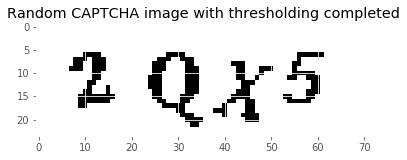

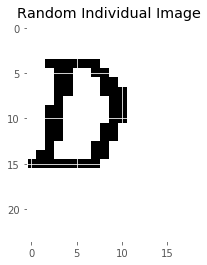

Matrix Representation of individual image
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [7]:
rand = np.random.randint(len(captcha_arr))
plt.imshow(captcha_arr[rand].reshape(IMG_HEIGHT, IMG_WIDTH*CAP_SIZE), cmap = 'gray')
plt.title('Random CAPTCHA image with thresholding completed')
plt.show()
plt.imshow(X_train[rand].reshape(IMG_HEIGHT,IMG_WIDTH), cmap = 'gray')
plt.title('Random Individual Image')
plt.show()
print('Matrix Representation of individual image')
print((X_train[rand]).reshape(IMG_HEIGHT,IMG_WIDTH))

In [8]:
# t-sne visualization: 432 features -> 2 features
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40)
X_train_tsne2d = tsne.fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 31428 samples in 5.092s...
[t-SNE] Computed neighbors for 31428 samples in 1164.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 31428
[t-SNE] Computed conditional probabilities for sample 2000 / 31428
[t-SNE] Computed conditional probabilities for sample 3000 / 31428
[t-SNE] Computed conditional probabilities for sample 4000 / 31428
[t-SNE] Computed conditional probabilities for sample 5000 / 31428
[t-SNE] Computed conditional probabilities for sample 6000 / 31428
[t-SNE] Computed conditional probabilities for sample 7000 / 31428
[t-SNE] Computed conditional probabilities for sample 8000 / 31428
[t-SNE] Computed conditional probabilities for sample 9000 / 31428
[t-SNE] Computed conditional probabilities for sample 10000 / 31428
[t-SNE] Computed conditional probabilities for sample 11000 / 31428
[t-SNE] Computed conditional probabilities for sample 12000 / 31428
[t-SNE] Computed conditional probabilities for

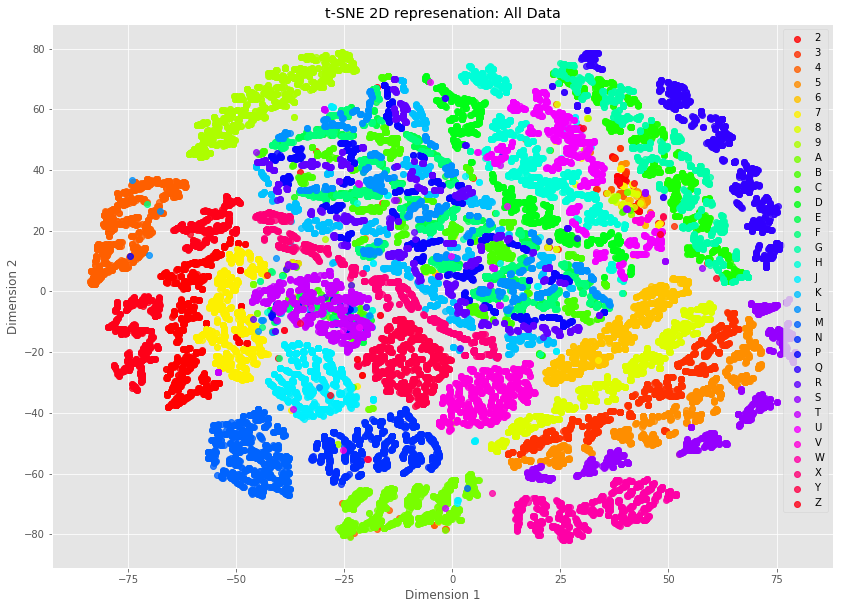

In [22]:
#t-SNE visualization
fig = plt.figure(figsize=(14, 10))
import matplotlib.cm as cm
labels = list(np.unique(y_train))
colors = cm.hsv(np.linspace(0, 1, number_of_labels))

for l, c, co, in zip(labels, colors, range(number_of_labels)):
    indices = np.where(y_train == l)
    plt.scatter(X_train_tsne2d[indices, 0],X_train_tsne2d[indices, 1],color=c,linewidth='1',alpha=0.8,label=l)#marker='o'
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE 2D represenation: All Data')
plt.legend(loc='best')
plt.savefig('rainbow-01.png')
plt.show(block=False)

In [10]:
%%time
#Unregularized Model training
from sklearn import svm
model_ovr = svm.SVC(kernel='linear', decision_function_shape = 'ovr')
model_ovr.fit(X_train,y_train)

Wall time: 1min 45s


In [11]:
#Testing data generation
X_test, y_test, captcha_arr, captcha_labels = captcha_dataset(X_test_i, y_test_i, 'test')

In [12]:
%%time
from sklearn.metrics import accuracy_score

y_pred_ovr = model_ovr.predict(X_test)
print('Character level accuracy score: ',round(accuracy_score(y_test,y_pred_ovr),4))

Character level accuracy score:  0.9789
Wall time: 1min 11s


In [14]:
#Calculating image lvel accuracy
print('Number of test digits passed: ',y_test.shape[0])
images_test = []
images_pred = []
character_counter = 0
current_characters_test = []
current_characters_pred = []
for i in range(y_test.shape[0]):
    if(character_counter < 4):
        current_characters_test.append(y_test[i])
        current_characters_pred.append(y_pred_ovr[i])
        character_counter += 1
    else:
        images_test.append(current_characters_test)
        images_pred.append(current_characters_pred)
        character_counter = 1
        current_characters_test = [y_test[i]]
        current_characters_pred = [y_pred_ovr[i]]
images_test.append(current_characters_test)
images_pred.append(current_characters_pred)

print('Verification: Number of images created: ',len(images_test))
print('Number of digits passed/4: ',y_test.shape[0]/4)

Number of test digits passed:  7964
Verification: Number of images created:  1991
Number of digits passed/4:  1991.0


In [15]:
images_correctly_classified = 0
for i in range(len(images_test)):
    if (images_test[i] == images_pred[i]):
        images_correctly_classified += 1
print('Accuracy score at image level: ',round(images_correctly_classified/len(images_test),4))

Accuracy score at image level:  0.9327


In [14]:
##K-Fold Cross Validation

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
num_folds = 5
k_fold = KFold(num_folds)
SVM_param_values = np.logspace(-4, 2, 10)
arg_max = None
best_c = None
SVM_max_cross_val_score = -np.inf

SVM_f1_scores = []
for h in SVM_param_values:
    SVM_fold_scores = []
    for training, testing in k_fold.split(X_train):
        SVM_method = svm.LinearSVC(C = h)
        SVM_method.fit(X_train[training],y_train[training])
        SVM_predict = SVM_method.predict(X_train[testing])
        SVM_fold_scores.append(f1_score(y_train[testing],SVM_predict,labels = None, pos_label=1,sample_weight=None,average='weighted'))
    SVM_f1_scores.append(np.mean(SVM_fold_scores))

best_C = SVM_param_values[np.argmax(SVM_f1_scores)]

In [16]:
%%time
# Regularized Model training
from sklearn import svm
model_cv = svm.LinearSVC(C = best_C) ##regularized l2 by default
model_cv.fit(X_train,y_train)

Wall time: 1min 57s


In [17]:
from sklearn.metrics import accuracy_score

y_pred_cv = model_cv.predict(X_test)
print('Character level accuracy score: ',round(accuracy_score(y_test,y_pred_cv),4))
#Calculating image lvel accuracy
print('Number of test digits passed: ',y_test.shape[0])
images_test = []
images_pred = []
character_counter = 0
current_characters_test = []
current_characters_pred = []
for i in range(y_test.shape[0]):
    if(character_counter < 4):
        current_characters_test.append(y_test[i])
        current_characters_pred.append(y_pred_cv[i])
        character_counter += 1
    else:
        images_test.append(current_characters_test)
        images_pred.append(current_characters_pred)
        character_counter = 1
        current_characters_test = [y_test[i]]
        current_characters_pred = [y_pred_cv[i]]
images_test.append(current_characters_test)
images_pred.append(current_characters_pred)

print('Verification: Number of images created: ',len(images_test))
print('Number of digits passed/4: ',y_test.shape[0]/4)

images_correctly_classified = 0
for i in range(len(images_test)):
    if (images_test[i] == images_pred[i]):
        images_correctly_classified += 1
print('Accuracy score at image level: ',round(images_correctly_classified/len(images_test),4))

Character level accuracy score:  0.9075
Number of test digits passed:  7964
Verification: Number of images created:  1991
Number of digits passed/4:  1991.0
Accuracy score at image level:  0.6936


## Attempt of Neural Network Classification

In [16]:
import tensorflow as tf
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
from keras import models, layers

onehot = np.identity(number_of_labels)

all_labels = {}
for i in range(number_of_labels):
    all_labels[label_list[i]] = onehot[i]

training_labels = [all_labels[y] for y in y_train]
testing_labels = [all_labels[y] for y in y_test]

training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

C:\anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
model_basic = models.Sequential()
model_basic.add(layers.Dense(number_of_labels, activation = 'softmax',input_shape = (IMG_HEIGHT*IMG_WIDTH,)))
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_basic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                13856     
Total params: 13,856
Trainable params: 13,856
Non-trainable params: 0
_________________________________________________________________


In [18]:
model_basic.fit(X_train, training_labels, epochs=10, batch_size=32)

Epoch 1/10
31428/31428 [==============================] - 3s 84us/step - loss: 2.0637 - acc: 0.4816
Epoch 2/10
31428/31428 [==============================] - 2s 79us/step - loss: 1.2259 - acc: 0.7055
Epoch 3/10
31428/31428 [==============================] - 3s 81us/step - loss: 0.9916 - acc: 0.7689
Epoch 4/10
31428/31428 [==============================] - 3s 82us/step - loss: 0.8551 - acc: 0.8076
Epoch 5/10
31428/31428 [==============================] - 3s 81us/step - loss: 0.7650 - acc: 0.8326
Epoch 6/10
31428/31428 [==============================] - 3s 80us/step - loss: 0.6999 - acc: 0.8488
Epoch 7/10
31428/31428 [==============================] - 2s 77us/step - loss: 0.6484 - acc: 0.8628
Epoch 8/10
31428/31428 [==============================] - ETA: 0s - loss: 0.6075 - acc: 0.872 - 2s 78us/step - loss: 0.6081 - acc: 0.8726
Epoch 9/10
31428/31428 [==============================] - 3s 80us/step - loss: 0.5772 - acc: 0.8785
Epoch 10/10
31428/31428 [==============================] - 2s 

In [19]:
test_loss, test_acc = model_basic.evaluate(X_test, testing_labels)
print('Test Loss:', test_loss, 'Test accuracy:', test_acc)

7964/7964 [==============================] - 0s 52us/step
Test Loss: 0.5958209924665544 Test accuracy: 0.882847815078446


In [20]:
model_advance = models.Sequential()
model_advance.add(layers.Conv2D(number_of_labels, (3,3), activation='relu',input_shape = (IMG_WIDTH,IMG_HEIGHT,1)))
model_advance.add(layers.MaxPool2D((2,2)))
model_advance.add(layers.Flatten())
model_advance.add(layers.Dense(number_of_labels, activation = 'softmax'))
model_advance.summary()
model_advance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_advance.fit(X_train.reshape(X_train.shape[0],IMG_WIDTH,IMG_HEIGHT,-1), training_labels, epochs=10, batch_size=32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 22, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 11, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2816)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                90144     
Total params: 90,464
Trainable params: 90,464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
31428/31428 [==============================] - 15s 487us/step - loss: 0.9901 - acc: 0.7668
Epoch 2/10
31428/31428 [==============================] - 14s 458us/step - loss: 0.3091 - acc: 0.9402
Epoch 3/10
31428/31428 [==============================] - 14s 442u

In [21]:
test_loss, test_acc = model_advance.evaluate(X_test.reshape(len(X_test),IMG_WIDTH,IMG_HEIGHT,-1), testing_labels)
print('Test Loss:', test_loss, 'Test accuracy:', test_acc)

7964/7964 [==============================] - 2s 219us/step
Test Loss: 0.2184217637459762 Test accuracy: 0.9748869914615771
